# 🍵 SKM-TEA Dataset Preprocssing Tutorial

This tutorial is for visualising the preprosessing steps taken to work with the skm-tea dataset in lateral view. Within this tutorial only the raw track will be used to show the limitations and the solutions given to use the dataset in a different anatomical view

## 📡 Downloading the Data
Let's download a [mini version](https://huggingface.co/datasets/arjundd/skm-tea-mini) of the SKM-TEA dataset from Huggingface. This mini dataset was created for building demos/tutorials with the SKM-TEA dataset. **Do not use this dataset for reporting/publication purposes**

*NOTE*: This download process can take ~5-8 minutes.

> If you would like to set up up the full SKM-TEA dataset on your machine, follow [these instructions](https://github.com/StanfordMIMI/skm-tea/blob/main/DATASET.md).

# Determine a local directory to save the files

In [ ]:
dataset_dir = "/data/projects/recon/data/public/multitask/skm-tea/v1-release/files_recon_calib-24/" ##Local Directory

In [ ]:
import os
from tqdm import tqdm


url = "https://huggingface.co/datasets/arjundd/skm-tea-mini/resolve/main/v1-release"
force_download = False

if force_download:
  !rm -rf $dataset_dir

if not os.path.isdir(dataset_dir):
  os.makedirs(dataset_dir)
  for fname in ["all_metadata.csv", "annotations/v1.0.0/train.json", "annotations/v1.0.0/val.json", "annotations/v1.0.0/test.json"]:
    out = f"{dataset_dir}/{fname}"
    os.makedirs(os.path.dirname(out), exist_ok=True)
    !wget -q $url/$fname -O $out


  for fname in tqdm(["dicoms", "files_recon_calib-24", "image_files", "segmentation_masks"], disable=False):
    !wget -c $url/"tarball"/$fname".tar.gz" -O - | tar -xz -C $dataset_dir/

!ls

## Some functions which will be used during this tutorial


In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import nibabel as nib
from typing import Union, Sequence
import torch
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
import h5py
from skimage.color import label2rgb
from atommic.collections.common.parts.transforms import Masker
from atommic.collections.common.data.subsample import create_masker

In [2]:
# Function for plotting MRI scans



def get_scaled_image(
    x: Union[torch.Tensor, np.ndarray], percentile=0.99, clip=False
):
  """Scales image by intensity percentile (and optionally clips to [0, 1]).

  Args:
    x (torch.Tensor | np.ndarray): The image to process.
    percentile (float): The percentile of magnitude to scale by.
    clip (bool): If True, clip values between [0, 1]

  Returns:
    torch.Tensor | np.ndarray: The scaled image.
  """
  is_numpy = isinstance(x, np.ndarray)
  if is_numpy:
    x = torch.as_tensor(x)

  scale_factor = torch.quantile(x, percentile)
  x = x / scale_factor
  if clip:
    x = torch.clip(x, 0, 1)

  if is_numpy:
    x = x.numpy()

  return x


def plot_images(
    images, processor=None, disable_ticks=True, titles: Sequence[str]=None,
    ylabel: str=None, xlabels: Sequence[str]=None, cmap: str="gray",
    show_cbar: bool = False, overlay = None, opacity: float = 0.3,
    hsize=5, wsize=5, axs=None,fontsize =20
):
  """Plot multiple images in a single row.

  Add an overlay with the `overlay=` argument.
  Add a colorbar with `show_cbar=True`.
  """
  def get_default_values(x, default=""):
    if x is None:
      return [default] * len(images)
    return x

  titles = get_default_values(titles)
  ylabels = get_default_values(images)
  xlabels = get_default_values(xlabels)

  N = len(images)
  if axs is None:
    fig, axs = plt.subplots(1, N, figsize=(wsize * N, hsize))
  else:
    assert len(axs) >= N
    fig = axs.flatten()[0].get_figure()
  k = 0
  for ax, img, title, xlabel in zip(axs, images, titles, xlabels):
    if processor is not None:
      img = processor(img)
    if type(cmap)==list:
        im = ax.imshow(img, cmap=cmap[k])
        if type(show_cbar)==list:
            if show_cbar[k]:
                fig.subplots_adjust(right=0.8)
                cbar_ax = fig.add_axes([0.85, 0.2, 0.01, 0.60])
                fig.colorbar(im, cax=cbar_ax)
    else:
      im = ax.imshow(img, cmap=cmap)
    k = k+1
    ax.set_title(title,fontsize=fontsize)
    ax.set_xlabel(xlabel)


  if type(overlay) ==list:
    for i,ax in enumerate(axs.flatten()):
      if overlay[i] is not None:
        im = ax.imshow(overlay[i], alpha=opacity)


  if disable_ticks:
    for ax in axs.flatten():
      ax.get_xaxis().set_ticks([])
      ax.get_yaxis().set_ticks([])

  return axs


In [3]:
# Function for transforming segmentation classes into one hot
def categorical_to_one_hot(x, channel_dim: int = 1, background=0, num_categories=None, dtype=None):
    """Converts categorical predictions to one-hot encoded predictions.

    Args:
        x (torch.Tensor | np.ndarray): Categorical array or tensor.
        channel_dim (int, optional): Channel dimension for output tensor.
        background (int | NoneType, optional): The numerical label of the
            background category. If ``None``, assumes that the background is
            a class that should be one-hot encoded.
        num_categories (int, optional): Number of categories (excluding background).
            Defaults to the ``max(x) + 1``.
        dtype (type, optional): Data type of the output.
            Defaults to boolean (``torch.bool`` or ``np.bool``).

    Returns:
        torch.Tensor | np.ndarray: One-hot encoded predictions.
    """
    is_ndarray = isinstance(x, np.ndarray)
    if is_ndarray:
        x = torch.from_numpy(x)

    if num_categories is None:
        num_categories = torch.max(x).type(torch.long).cpu().item()
    num_categories += 1

    shape = x.shape
    out_shape = (num_categories,) + shape

    if dtype is None:
        dtype = torch.bool
    default_value = True if dtype == torch.bool else 1
    if x.dtype != torch.long:
        x = x.type(torch.long)

    out = torch.zeros(out_shape, dtype=dtype, device=x.device)
    out.scatter_(0, x.reshape((1,) + x.shape), default_value)
    if background is not None:
        out = torch.cat([out[0:background], out[background + 1 :]], dim=0)
    if channel_dim != 0:
        if channel_dim < 0:
            channel_dim = out.ndim + channel_dim
        order = (channel_dim,) + tuple(d for d in range(out.ndim) if d != channel_dim)
        out = out.permute(tuple(np.argsort(order)))
        out = out.contiguous()

    if is_ndarray:
        out = out.numpy()
    return out

In [4]:
# Function for combining one hot encoded classes
def collect_mask(
    mask: np.ndarray,
    index: Sequence[Union[int, Sequence[int], int]],
    out_channel_first: bool = True,
):
    """Collect masks by index.

    Collated indices will be summed. For example, `index=(1,(3,4))` will return
    `np.stack(mask[...,1], mask[...,3]+mask[...,4])`.

    TODO: Add support for adding background.

    Args:
        mask (ndarray): A (...)xC array.
        index (Sequence[int]): The index/indices to select in mask.
            If sub-indices are collated, they will be summed.
        out_channel_first (bool, optional): Reorders dimensions of output mask to Cx(...)
    """
    if isinstance(index, int):
        index = (index,)

    if not any(isinstance(idx, Sequence) for idx in index):
        mask = mask[..., index]
    else:
        o_seg = []
        for idx in index:
            c_seg = mask[..., idx]
            if isinstance(idx, Sequence):
                c_seg = np.sum(c_seg, axis=-1)
            o_seg.append(c_seg)
        mask = np.stack(o_seg, axis=-1)

    if out_channel_first:
        last_idx = len(mask.shape) - 1
        mask = np.transpose(mask, (last_idx,) + tuple(range(0, last_idx)))

    return mask

In [5]:
# Function for transforming segmentation classes into categorical
def one_hot_to_categorical(x, channel_dim: int = 1, background=False):
    """Converts one-hot encoded predictions to categorical predictions.

    Args:
        x (torch.Tensor | np.ndarray): One-hot encoded predictions.
        channel_dim (int, optional): Channel dimension.
            Defaults to ``1`` (i.e. ``(B,C,...)``).
        background (bool, optional): If ``True``, assumes index 0 in the
            channel dimension is the background.

    Returns:
        torch.Tensor | np.ndarray: Categorical array or tensor. If ``background=False``,
        the output will be 1-indexed such that ``0`` corresponds to the background.
    """
    is_ndarray = isinstance(x, np.ndarray)
    if is_ndarray:
        x = torch.as_tensor(x)

    if background is not None and background is not False:
        out = torch.argmax(x, channel_dim)
    else:
        out = torch.argmax(x.type(torch.long), dim=channel_dim) + 1
        out = torch.where(x.sum(channel_dim) == 0, torch.tensor([0], device=x.device), out)

    if is_ndarray:
        out = out.numpy()
    return out

In [6]:
# Load the corresponding data
from  pathlib import Path
dataset_dir = '/data/projects/recon/data/public/multitask/skm-tea/v1-release/'
meta_dir = Path(dataset_dir) / 'all_metadata.csv'
meta_data = pd.read_csv(meta_dir)

recon_file = Path(dataset_dir) / "files_recon_calib-24/"

seg_file = Path(dataset_dir)  / str("segmentation_masks/raw-data-track/")

patient_id = 'MTR_133' #meta_data['MTR_ID'][60]
print(patient_id)
meta_data = meta_data[meta_data['MTR_ID']==patient_id]

with h5py.File(str(recon_file)+"/"+patient_id+".h5", "r") as f:
    print(f.keys())
    kspace_org= f["kspace"][:, :, :, :, :]  # Shape: (x, ky, kz, #echos, #coils)
    maps_org= f["maps"][:, :, :, :, :]      # Shape: (x, ky, kz, #coils, #maps) - maps are the same for both echos
    mask_org = f["masks"]["poisson_4.0x"][()]
    scan_org = f["target"][()]
segmentation_org = nib.load(str(seg_file)+"/"+patient_id+'.nii.gz')
segmentation_one = categorical_to_one_hot(segmentation_org.get_fdata(),channel_dim=-1)
segmentation_one_org = collect_mask(segmentation_one, (0, 1, (2, 3), (4, 5)), out_channel_first=False)

crop_scale = [0.5,0.5,0.5] #Option to crop


MTR_133
<KeysViewHDF5 ['kspace', 'maps', 'masks', 'target']>


(512, 512, 160, 3)


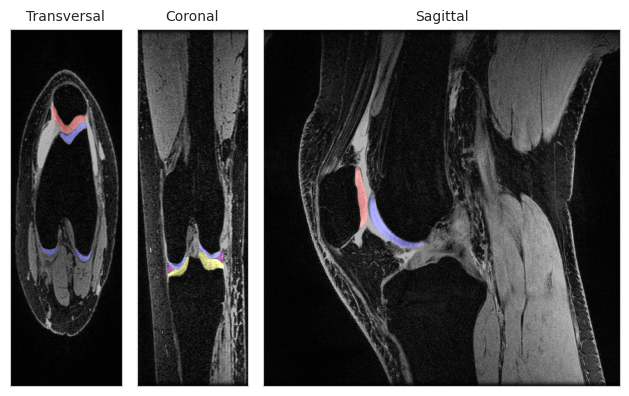

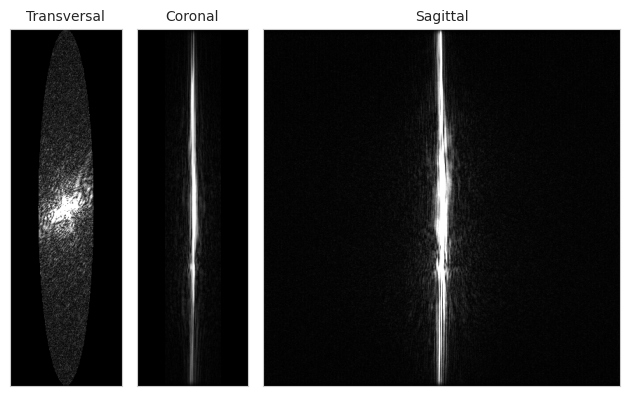

In [7]:

seg_colorized = label2rgb(one_hot_to_categorical(segmentation_one_org[:,:,:],channel_dim=-1), bg_label=0)
print(seg_colorized.shape)
fig, axs = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 1,3.2]})
plot_images([get_scaled_image(np.abs(scan_org)[256,:,:,0,0], 0.99, clip=True),get_scaled_image(np.abs(scan_org)[:,256,:,0,0], 0.99, clip=True),get_scaled_image(np.abs(scan_org)[:,:,80,0,0], 0.99, clip=True)],axs=axs,titles=['Transversal',"Coronal","Sagittal"],fontsize =10,overlay=[seg_colorized[256,:,:],seg_colorized[:,256,:],seg_colorized[:,:,80]])
fig.tight_layout()
fig.savefig('/scratch/tmpaquaij/Figures/Spatial_orientation_segmentation.png')
fig, axs = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 1,3.2]})
plot_images([get_scaled_image(np.abs(kspace_org)[256,:,:,0,0], 0.99, clip=True),get_scaled_image(np.abs(kspace_org)[:,256,:,0,0], 0.99, clip=True),get_scaled_image(np.abs(kspace_org)[:,:,80,0,0], 0.99, clip=True)],axs=axs,titles=['Transversal',"Coronal","Sagittal"],fontsize =10)
fig.tight_layout()
fig.savefig('/scratch/tmpaquaij/Figures/Spatial_orientation_kspace.png')

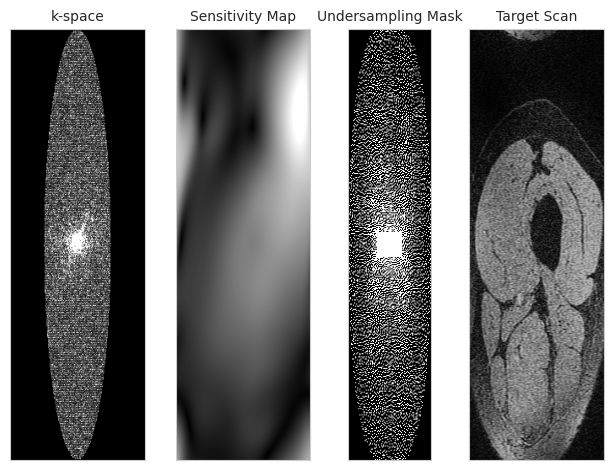

In [8]:
sl=7
hsize = 5
wsize = hsize / scan_org.shape[1] * scan_org.shape[2]
seg_colorized = label2rgb(one_hot_to_categorical(segmentation_one_org[sl,:,:],channel_dim=-1), bg_label=0)
fig, axs = plt.subplots(1, 4, gridspec_kw={'width_ratios': [1, 1,0.75,1]})
plot_images([get_scaled_image(np.abs(kspace_org)[sl,:,:,0,0], 0.99, clip=True),get_scaled_image(np.abs(maps_org)[sl,:,:,0,0], 0.99, clip=True),np.abs(mask_org),get_scaled_image(np.abs(scan_org)[sl,:,:,0,0], 0.99, clip=True)],axs=axs,titles=['k-space',"Sensitivity Map","Undersampling Mask","Target Scan"],fontsize =10,overlay=[None,None,None,seg_colorized])
fig.tight_layout()
fig.savefig('/scratch/tmpaquaij/Figures/Dataset_overview.png')

In [15]:
#Remove undersampling kspace and prepare for lateral reconstruction

kspace = torch.fft.fftshift(torch.fft.fft(torch.fft.ifftshift(torch.as_tensor(kspace_org),dim=0),dim=0),dim=0)
kspace = torch.fft.fftshift(torch.fft.ifft(torch.fft.ifftshift(kspace,dim=2),dim=2),dim=2)


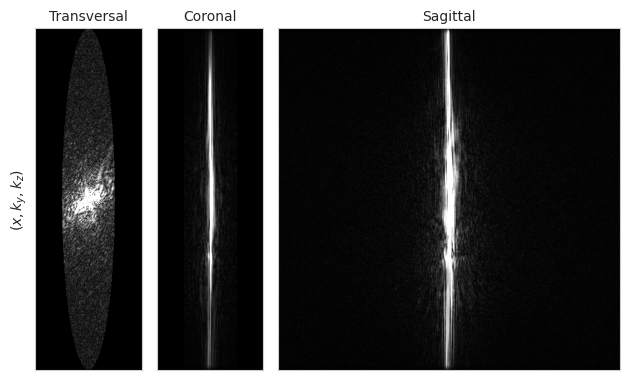

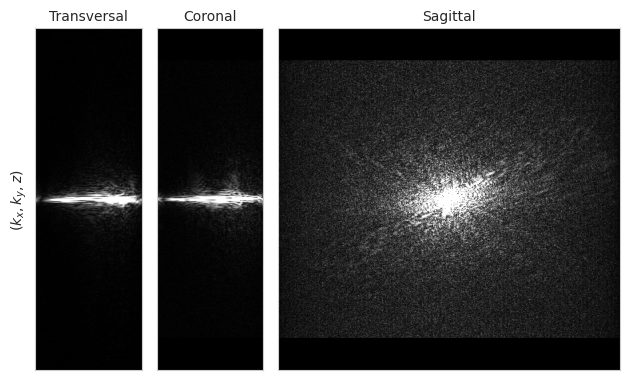

In [16]:
fig, axs = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 1,3.2]})
plot_images([get_scaled_image(np.abs(kspace_org)[256,:,:,0,0], 0.99, clip=True),get_scaled_image(np.abs(kspace_org)[:,256,:,0,0], 0.99, clip=True),get_scaled_image(np.abs(kspace_org)[:,:,80,0,0], 0.99, clip=True)],axs=axs,titles=['Transversal',"Coronal","Sagittal"],fontsize =10)
axs[0].set_ylabel("$(x,k_{y},k_{z})$", fontsize=10)
fig.tight_layout()
fig.savefig('/scratch/tmpaquaij/Figures/Spatial_orientation_kspace_before.png')
fig, axs = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 1,3.2]})
plot_images([get_scaled_image(np.abs(kspace)[256,:,:,0,0], 0.99, clip=True),get_scaled_image(np.abs(kspace)[:,256,:,0,0], 0.99, clip=True),get_scaled_image(np.abs(kspace)[:,:,80,0,0], 0.99, clip=True)],axs=axs,titles=['Transversal',"Coronal","Sagittal"],fontsize =10)
axs[0].set_ylabel("$(k_{x},k_{y},z)$", fontsize=10)
fig.tight_layout()
fig.savefig('/scratch/tmpaquaij/Figures/Spatial_orientation_kspace_after.png')


In [17]:
kspace = torch.fft.fftshift(torch.fft.fft(torch.fft.ifftshift(kspace,dim=2),dim=2),dim=2)
kspace = kspace[int(kspace.shape[0] / 2 - (kspace.shape[0] * crop_scale[0] / 2)):int(kspace.shape[0] / 2 + (kspace.shape[0] * crop_scale[0] / 2)),
                            int(kspace.shape[1] / 2 - (kspace.shape[1] * crop_scale[1] / 2)):int(kspace.shape[1] / 2 + (kspace.shape[1] * crop_scale[1] / 2)),
                            int(kspace.shape[2] / 2 - (kspace.shape[2] * crop_scale[2] / 2)):int(kspace.shape[2] / 2 + (kspace.shape[2] * crop_scale[2] / 2)),
                            :,
                            :]
kspace = torch.fft.fftshift(torch.fft.ifft(torch.fft.ifftshift(kspace,dim=2),dim=2),dim=2)

kspace = np.transpose(kspace,(2,0,1,3,4)) ## z-axis to first dimension

In [18]:
####Interpolate Reference Grid ####
arr_shape = np.transpose(kspace_org,(2, 0, 1, 3,4)).shape[0:3]

pixelsize_x_old = 0.3125  ## Can probably be determined from meta_data but not included yet
pixelsize_y_old = 0.3125
slice_thickness_old = meta_data['SliceThickness'].iloc[0]

pixelsize_x_new = 0.3125*(1/crop_scale[0])
pixelsize_y_new = 0.3125*(1/crop_scale[1])
slice_thickness_new =meta_data['SliceThickness'].iloc[0] *(1/crop_scale[2])


x_old = np.linspace(0, (arr_shape[1] - 1) * pixelsize_x_old, arr_shape[1])
y_old = np.linspace(0, (arr_shape[2] - 1) * pixelsize_y_old, arr_shape[2])
z_old = np.arange(0, (arr_shape[0])) * slice_thickness_old

x_new = kspace.shape[1]
y_new = kspace.shape[2]
z_new = kspace.shape[0]

# pts is the new grid
pts = np.indices((z_new, x_new, y_new)).transpose((1, 2, 3, 0))
pts = pts.reshape(1, z_new * x_new * y_new, 1, 3).reshape(z_new * x_new * y_new, 3)
pts = np.array(pts, dtype=float)
pts[:, 1] = pts[:, 1] * pixelsize_x_new
pts[:, 2] = pts[:, 2] * pixelsize_y_new
pts[:, 0] = pts[:, 0] * slice_thickness_new

In [19]:
##### Interpolate Segmentation  #####
target_shape = np.array(
    [z_new,x_new,y_new,segmentation_one_org.shape[3]], int)
print(target_shape)
new_segmentation = np.zeros(shape = target_shape,dtype = int)
for l in range(segmentation_one_org.shape[-1]):
    arr = np.transpose(segmentation_one_org[:,:,:,l],(2,0,1))
    my_interpolating_object = RegularGridInterpolator((z_old, x_old, y_old), arr, method='nearest',bounds_error=False)
    interpolated_data = my_interpolating_object(pts)
    interpolated_data = interpolated_data.reshape(z_new, x_new, y_new)
    new_segmentation[:,:,:,l] = interpolated_data
    print('Interpolated Segmentaion Class:', l)
new_segmentation = np.transpose(new_segmentation,(0,1,2,3))
print(np.unique(new_segmentation.reshape(-1,1)),new_segmentation.shape)

[ 80 256 256   4]
Interpolated Segmentaion Class: 0
Interpolated Segmentaion Class: 1
Interpolated Segmentaion Class: 2
Interpolated Segmentaion Class: 3
[0 1] (80, 256, 256, 4)


In [69]:
segmentation_labels_bg = np.zeros((new_segmentation.shape[0],new_segmentation.shape[1], new_segmentation.shape[2]))
idx_background = np.where(np.sum(new_segmentation, axis=-1) == 0)
segmentation_labels_bg[idx_background] = 1
segmentation_labels_def= np.concatenate((np.expand_dims(segmentation_labels_bg,axis=-1),new_segmentation), axis=-1)
segmentation_labels_def_cat= one_hot_to_categorical(segmentation_labels_def,-1,background=0)
count = np.bincount(segmentation_labels_def_cat.reshape(-1))
total = np.sum(count)
class_weight =(1/count)*(total/5)
print(float(class_weight[3]))

123.9451536643026


In [85]:
image = torch.zeros((3,5,256,256))
intermdiate_predictions = [image,image,image]
intermdiate_predictions = torch.cat([i.unsqueeze(1) for i in intermdiate_predictions],dim=1)
batch_size = intermdiate_predictions.shape[0] // 3
intermdiate_predictions = intermdiate_predictions.reshape(batch_size, 3, *intermdiate_predictions.shape[1:])
print(intermdiate_predictions.shape)

torch.Size([1, 3, 3, 5, 256, 256])


In [25]:

##### Interpolate Sensitivity maps  #####
target_shape = np.array([z_new,x_new,y_new,maps_org.shape[3],maps_org.shape[4]],int)
new_arr = np.empty(shape=target_shape, dtype=complex)
for k in range(maps_org.shape[-2]):
    map = np.transpose(maps_org[:,:,:,k,0],(2,0,1))
    my_interpolating_object = RegularGridInterpolator((z_old, x_old, y_old), map, method='nearest',bounds_error=False)
    interpolated_data = my_interpolating_object(pts)
    interpolated_data = interpolated_data.reshape(z_new, x_new, y_new)
    new_arr[:, :, :, k, 0] = interpolated_data
    print('Interpolated Sensitivity map:',k+1)
maps = np.transpose(new_arr,(0,1,2,4,3))
print('Interpolated all sensitivity coils',maps.shape)

Interpolated Sensitivity map: 1
Interpolated Sensitivity map: 2
Interpolated Sensitivity map: 3
Interpolated Sensitivity map: 4
Interpolated Sensitivity map: 5
Interpolated Sensitivity map: 6
Interpolated Sensitivity map: 7
Interpolated Sensitivity map: 8
Interpolated all sensitivity coils (80, 256, 256, 1, 8)


In [26]:

acceleration = [4]
shift_mask = False
mask_type = "gaussian2d"

mask_func = None
mask_center_scale = 0.02


if len(acceleration) == 1:
    accelerations = acceleration * 2
center_fractions = [1]
center_fractions = list(center_fractions)
if len(center_fractions) == 1:
    center_fractions = center_fractions * 2
mask_center_scale = 0.02

mask_func = [create_masker(mask_type, center_fractions, acceleration)]



mask_func = Masker(mask_func=mask_func,spatial_dims=[1,2])
mask_func.__call__(kspace)
masked_data, masks, accelerations= mask_func(kspace[40,:,:,0,:])
print(masks[0].shape)


torch.Size([256, 256, 1])


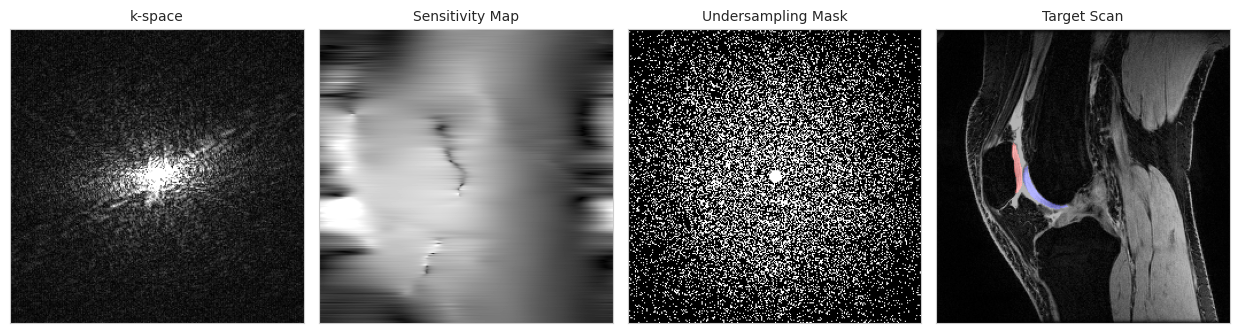

In [27]:
sl=40
hsize = 10
wsize = hsize / scan_org.shape[1] * scan_org.shape[2]
fig, axs = plt.subplots(1, 4, figsize=(4 * wsize, 1 * hsize))
kspace_fft_4 = torch.fft.ifftshift(kspace[sl,:,:,:,:],dim=(0,1))
kspace_fft_5 = torch.fft.ifft2(kspace_fft_4,dim=(0,1))
kspace_fft_6 = torch.fft.fftshift(kspace_fft_5,dim=(0,1))
image_fft = kspace_fft_6 * torch.conj(torch.as_tensor(maps[sl,:,:,:,:]))
image_fft_sum =torch.sum(image_fft,dim=-1,keepdim=True)
seg_colorized = label2rgb(one_hot_to_categorical(new_segmentation[sl,:,:],channel_dim=-1), bg_label=0)
plot_images([get_scaled_image(np.abs(kspace)[sl,:,:,0,0], 0.99, clip=True),get_scaled_image(np.abs(maps)[sl,:,:,0,0], 0.99, clip=True),masks[0][:,:,0],get_scaled_image(np.abs(image_fft_sum)[:,:,0,0], 0.99, clip=True)],axs=axs,titles=['k-space',"Sensitivity Map","Undersampling Mask","Target Scan"],fontsize =10,overlay=[None,None,None,seg_colorized])
fig.tight_layout()
fig.savefig("/scratch/tmpaquaij/Figures/Data_Transformation_def.png")

In [ ]:
### Plot reconstructed scan ###
hsize = 5
wsize = hsize / kspace.shape[1] * kspace.shape[2]

seg_colorized = label2rgb(one_hot_to_categorical(new_segmentation[sl,:,:],channel_dim=-1), bg_label=0)
print(seg_colorized.shape)
fig, axs = plt.subplots(2, 3, figsize=(3 * wsize, 2 * hsize))
plot_images([np.abs(kspace)[sl,:,:,0,0],np.abs(kspace_fft_4.numpy())[...,0,0],np.abs(kspace_fft_5.numpy())[...,0,0]],axs=axs[0],processor=lambda x: get_scaled_image(x, 0.99, clip=True),titles=['Sagittal k-space','iffshift','ifft (2D)'],fontsize =12)
plot_images([np.abs(kspace_fft_6.numpy())[...,0,0],np.abs(image_fft.numpy())[...,0,0],np.abs(image_fft_sum.numpy())[...,0,0]],axs=axs[1],processor=lambda x: get_scaled_image(x, 0.99, clip=True),titles=['fftshift','Apply maps','Sum Coils'],fontsize =12,overlay=[None,None,seg_colorized])
plt.savefig('/scratch/tmpaquaij/Figures/Interpolation_rec_overview.png')

In [ ]:
#### Crop Sensitivity and Segmentation to compare with interpolation ###
maps_crop = maps_org[48:-48,:,40:-40,:,:]
maps_crop = np.transpose(maps_crop[int(maps_crop.shape[0]/2-(maps_crop.shape[0]*crop_scale[0]/2)):int(maps_crop.shape[0]/2+(maps_crop.shape[0]*crop_scale[0]/2)),
                int(maps_crop.shape[1]/2-(maps_crop.shape[1]*crop_scale[1]/2)):int(maps_crop.shape[1]/2+(maps_crop.shape[1]*crop_scale[1]/2)),
                int(maps_crop.shape[2]/2-(maps_crop.shape[2]*crop_scale[2]/2)):int(maps_crop.shape[2]/2+(maps_crop.shape[2]*crop_scale[2]/2)),
                :,
                :],(2,0,1,4,3))
segmentation_crop = segmentation_one_org[48:-48,:,40:-40,:]
segmentation_crop = np.transpose(segmentation_crop[int(segmentation_crop.shape[0]/2-(segmentation_crop.shape[0]*crop_scale[0]/2)):int(segmentation_crop.shape[0]/2+(segmentation_crop.shape[0]*crop_scale[0]/2)),
                int(segmentation_crop.shape[1]/2-(segmentation_crop.shape[1]*crop_scale[1]/2)):int(segmentation_crop.shape[1]/2+(segmentation_crop.shape[1]*crop_scale[1]/2)),
                int(segmentation_crop.shape[2]/2-(segmentation_crop.shape[2]*crop_scale[2]/2)):int(segmentation_crop.shape[2]/2+(segmentation_crop.shape[2]*crop_scale[2]/2)),
                :] ,(2,0,1,3))

In [ ]:
### Reconstruction with cropped Sensitivity maps ###
kspace_fft_4 = torch.fft.ifftshift(torch.from_numpy(kspace[sl,:,:,:,:]),dim=(0,1))
kspace_fft_5 = torch.fft.ifft2(kspace_fft_4,dim=(0,1))
kspace_fft_6 = torch.fft.fftshift(kspace_fft_5,dim=(0,1))
image_fft = kspace_fft_6 * torch.conj(torch.as_tensor(maps_crop[sl,:,:,:,:]))
image_fft_sum_crop =torch.sum(image_fft,dim=-1,keepdim=True)

In [ ]:
### Segmentation transform for colorized visualisation ###
seg_colorized_int = label2rgb(one_hot_to_categorical(new_segmentation[sl,:,:,:],channel_dim=-1), bg_label=0)
seg_colorized_crop = label2rgb(one_hot_to_categorical(segmentation_crop[sl,:,:,:],channel_dim=-1), bg_label=0)


In [ ]:
### Plot to compare interpolation vs cropping ###
hsize = 5
wsize = hsize / kspace.shape[1] * kspace.shape[2]
plot_images([np.abs(maps)[sl,:,:,0,0],np.abs(maps_crop)[sl,:,:,0,0]],processor=lambda x: get_scaled_image(x, 0.99, clip=True),titles=['Interpolated SENSE','Cropped SENSE'],fontsize =12,wsize=wsize,hsize=hsize)


hsize = 5
wsize = hsize / kspace.shape[1] * kspace.shape[2]
plot_images([seg_colorized_int,seg_colorized_crop],titles=['Interpolated Segmentation','Cropped Segmentation'],fontsize =12,wsize=wsize,hsize=hsize)

hsize = 5
wsize = hsize / kspace.shape[1] * kspace.shape[2]
plot_images([np.abs(image_fft_sum.numpy())[...,0,0],np.abs(image_fft_sum_crop.numpy())[...,0,0]],titles=['Interpolated Reconstruction','Cropped Reconstruction'],fontsize =12,wsize=wsize,hsize=hsize)

plt.savefig('/scratch/tmpaquaij/Figures/Cropped_vs_interpolation.png')